In [148]:
import numpy as np
import matplotlib.pyplot as plt

In [149]:
# import acceleromter data
data = np.genfromtxt(r'data/20steps.txt',delimiter=',',skip_header=25)

In [150]:
sample_rate = 20/1000 # rate in seconds


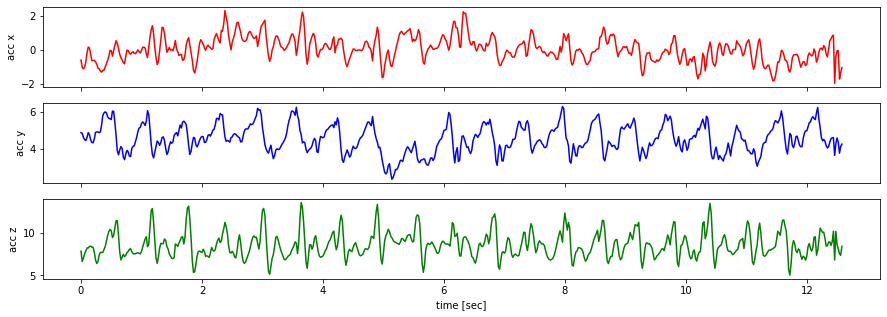

In [151]:
# plot accelerations data in each axes
fig, axs = plt.subplots(nrows=3, ncols=1,sharex=True, figsize=(15,5))

axs[0].plot(np.arange(len(data))*sample_rate,data[:,0],'-r')
axs[0].set_ylabel('acc x')

axs[1].plot(np.arange(len(data))*sample_rate,data[:,1],'-b')
axs[1].set_ylabel('acc y')

axs[2].plot(np.arange(len(data))*sample_rate,data[:,2],'-g')
axs[2].set_ylabel('acc z')

axs[2].set_xlabel('time [sec]')


plt.show()

In [152]:
# compute combined acceleromter magnitude
acc_magnitude = np.sqrt(data[:,0]**2 + data[:,1]**2 + data[:,2]**2)

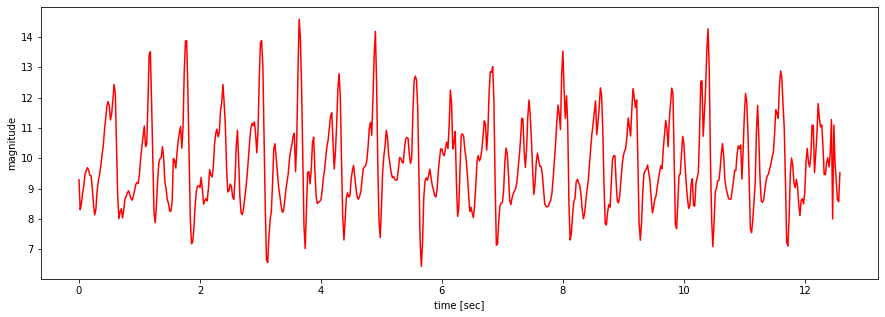

In [153]:
fig = plt.figure(figsize=(15,5))
plt.plot(np.arange(len(acc_magnitude))*sample_rate,acc_magnitude,'-r')
plt.ylabel('magnitude')
plt.xlabel('time [sec]')
plt.show()

# Peak Detection

In [154]:
def peak_detector(data, K):
    
    peaks =[]

    for i, datum in enumerate(data):
        if i > 0:
            if i-K < 0 :
            
                if datum >= max(data[:i]) and datum >=max(data[i+1:i+K+1]):
                    peaks.append(i)
                    time_from_last_peak = 0 

            elif i+K > len(data) :

                if datum >= max(data[i-K:i]) and datum >=max(data[i+1:]):
                    peaks.append(i)
                    time_from_last_peak = 0 
            else :

                if datum >= max(data[i-K:i]) and datum >=max(data[i+1:i+K+1]):
                        peaks.append(i)
                        time_from_last_peak = 0 



    return np.asarray(peaks)

In [155]:
# peak detection
K = int(0.4/sample_rate) # min distance between peaks threshold [samples]
peaks = peak_detector(acc_magnitude,K)

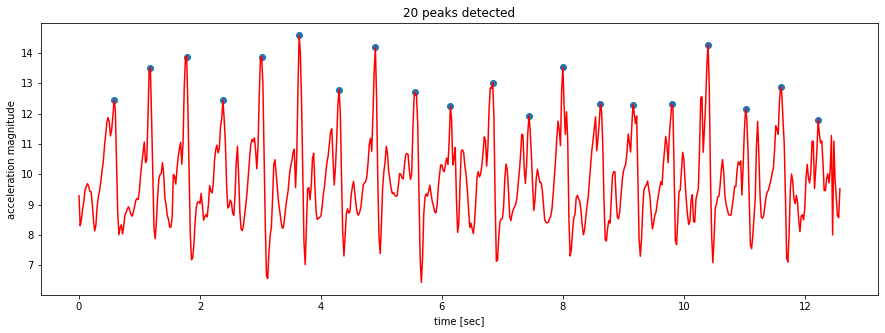

In [156]:
# plot result
fig = plt.figure(figsize=(15,5))
plt.plot(np.arange(len(acc_magnitude))*sample_rate,acc_magnitude,'-r')
plt.scatter(peaks*sample_rate,acc_magnitude[peaks])
plt.ylabel('acceleration magnitude')
plt.xlabel('time [sec]')
plt.title(str(len(peaks)) + ' peaks detected')
plt.show()

# Feature Analysis

Periodicity

In [157]:
def calculate_periodicity_thresholds(peaks, sample_rate):
    # calculate min and max time difference between neighboring peaks 

    d = np.diff(peaks)* sample_rate
    T_max = np.average(d) + 3* np.std(d)
    T_min = np.average(d) - 3* np.std(d)
    
    return T_max, T_min

In [158]:
T_max, T_min = calculate_periodicity_thresholds(peaks, sample_rate)

print('T max: ',T_max,' [sec]')
print('T min: ',T_min,' [sec]')

T max:  0.721384265417195  [sec]
T min:  0.5038788924775416  [sec]


In [159]:
def calculate_periodicity(i,peaks,sample_rate):
    # calculate min and max time difference between neighboring peaks 

    return (peaks[i] - peaks[i-1]) * sample_rate

Similarity

In [160]:
def calculate_similarity_threshold(acc_magnitude,peaks):
    # calculate similarity threshold between neighboring peaks 

    peaks_magnitude = acc_magnitude[peaks]
    d_even = np.abs(np.diff(peaks_magnitude[::2]))
    d_odd = np.abs(np.diff(peaks_magnitude[1::2]))
    d = np.vstack([d_even,d_odd])
    sim_threshold = -1*(np.average(d) + 3*np.std(d))
    
    return sim_threshold

In [161]:
sim_threshold = calculate_similarity_threshold(acc_magnitude,peaks)
print('similarity threshold: ' ,sim_threshold)

similarity threshold:  -2.925422087920306


In [162]:
def calculate_similarity(acc_magnitude,i,peaks):
    # calculate similarity  

    return -1*np.abs(acc_magnitude[peaks[i]]- acc_magnitude[peaks[i-2]])

Continuity

In [163]:
# parameters for continuity computation
M = 2 # number threshold of continuity
N = 4 # window size of continuity
var_threshold = 500 # variance threshold for motion recognition

In [164]:
def calculate_var_threshold(acc_magnitude,peaks,M,N):
    # determine continuity
    vars = []
    vars.append(np.var(acc_magnitude[0:peaks[0]]))
    for i in range(len(peaks)-1):
        vars.append(np.var(acc_magnitude[peaks[i]:peaks[i+1]]))
    vars = np.asarray(vars)
    return np.average(vars) - 3*np.std(vars)

In [165]:
var_threshold = calculate_var_threshold(acc_magnitude,peaks,M,N)
print('var threshold: ', var_threshold )

var threshold:  0.8201247609328728


In [166]:
def calculate_continuity(i,acc_magnitude,peaks,M,N,var_threshold):
    # determine continuity 
    sum = 0
    for j in range(i-N+1,i+1):
        var = np.var(acc_magnitude[peaks[j]:peaks[j+1]]) 
        if var > var_threshold: # motion recognition
            sum += 1
    if sum >= M:
        C = 1
    else:
        C = 0
    return C

# Simulation

In [191]:
K = 15
T_min = 0.3
T_max = 1
sim_threshold = -5
M = 2
N = 4
var_threshold = 0.7

In [192]:
# import acceleromter data
sim_data = np.genfromtxt(r'data/Playing_phone_and_then_10_steps.csv',delimiter=',',skip_header=25)
sim_data = sim_data[:,1:]


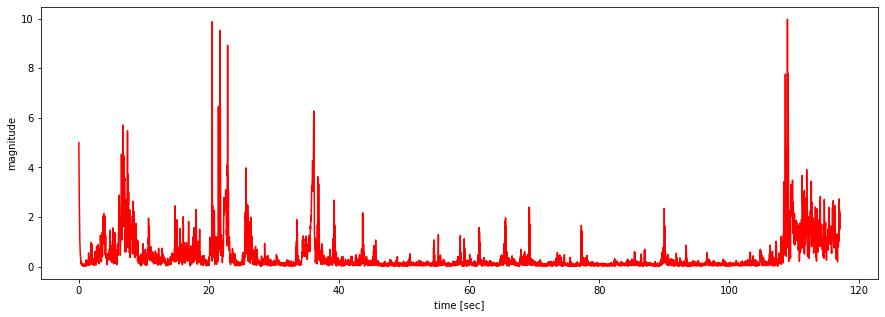

In [193]:
sample_rate = 10/1000 # rate in seconds
# compute combined acceleromter magnitude
acc_magnitude = np.sqrt(sim_data[:,0]**2 + sim_data[:,1]**2 + sim_data[:,2]**2)
fig = plt.figure(figsize=(15,5))
plt.plot(np.arange(len(acc_magnitude))*sample_rate,acc_magnitude,'-r')
plt.ylabel('magnitude')
plt.xlabel('time [sec]')
plt.show()

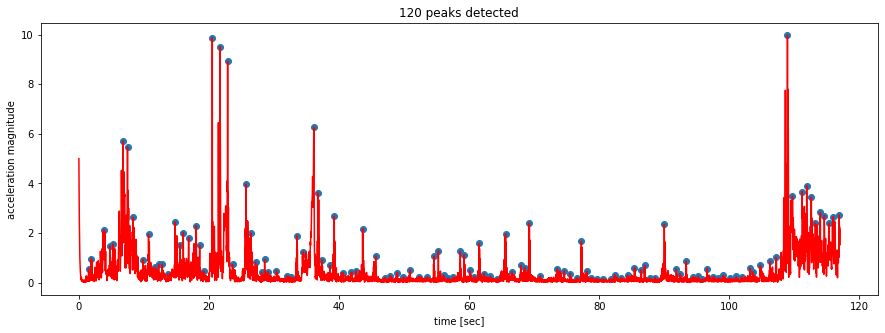

In [194]:
# peak detection
K = int(0.4/sample_rate) # min distance between peaks threshold [samples]
peaks = peak_detector(acc_magnitude,K)
# plot result
fig = plt.figure(figsize=(15,5))
plt.plot(np.arange(len(acc_magnitude))*sample_rate,acc_magnitude,'-r')
plt.scatter(peaks*sample_rate,acc_magnitude[peaks])
plt.ylabel('acceleration magnitude')
plt.xlabel('time [sec]')
plt.title(str(len(peaks)) + ' peaks detected')
plt.show()

In [195]:
# running simulation with the computed parameters
steps = []
steps_count = 0
for i in range(N-1,len(peaks)-1):
    C = calculate_continuity(i,acc_magnitude,peaks,M,N,var_threshold)
    # prints for debug
    print(C)
    print(calculate_similarity(acc_magnitude,i,peaks))
    print(calculate_periodicity(i,peaks,sample_rate))
    #
    if C == 0:
        continue
    elif calculate_similarity(acc_magnitude,i,peaks)<=sim_threshold:
        continue
    elif T_min<calculate_periodicity(i,peaks,sample_rate)<T_max:
        steps_count +=1
        steps.append(peaks[i])

steps = np.asarray(steps)
print('step count is: ',steps_count)



0
-0.5017747696152401
0.9500000000000001
0
-0.5715545307627838
0.43
1
-4.235336346824415
1.58
1
-3.9142268085426677
0.68
1
-3.0700011688493882
0.86
1
-4.551285442641099
1.52
0
-0.688647563669641
0.85
0
-0.2956274210205351
1.05
0
-1.2098121099292771
0.5
0
-0.11478944522819379
0.56
0
-0.4050989213986547
0.81
0
-1.7062748306563025
1.18
0
-1.1985375469138673
0.71
0
-0.43417956848158124
0.53
0
-0.2845131312298581
0.8300000000000001
0
-0.28568914311018156
1.11
0
-0.31406063997974654
0.58
0
-1.8480106305611996
0.68
0
-8.378009996457031
1.26
1
-9.062650169726965
1.2
1
-0.9558802873227012
1.16
1
-8.781556742968156
0.75
1
-4.946939121397938
2.08
0
-1.259234005972937
0.74
0
-3.1635785967953067
0.72
0
-1.5661761386845399
0.92
0
-0.12000758847730575
0.48
0
-0.019058100938699918
0.5
0
-0.45054770529198684
1.31
0
-0.17569904408817416
1.58
0
-0.25702467997481626
0.72
0
-1.6204216560387263
0.8300000000000001
0
-1.0108220556213259
1.0
1
-4.387192130162862
1.62
1
-2.388330986152429
0.6
1
-5.3625325130051

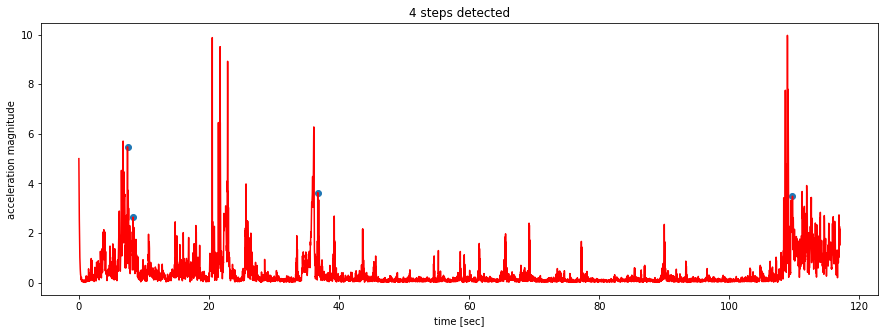

In [196]:
# plot result
fig = plt.figure(figsize=(15,5))
plt.plot(np.arange(len(acc_magnitude))*sample_rate,acc_magnitude,'-r')
plt.scatter(steps*sample_rate,acc_magnitude[steps])
plt.ylabel('acceleration magnitude')
plt.xlabel('time [sec]')
plt.title(str(len(steps)) + ' steps detected')
plt.show()